# XAU-TRY ENDEKSİ

In [229]:
# Veri okuma ve işleme adımında kullanılacak kütüphaneler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# !pip install tensorflow
import tensorflow as tf

# Model için kullanılacak kütüphaneler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Model değerlendirme ve veri ölçeklendirmede kullanılacak kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Uyarıları kapatmak için kullanılacak kütüphaneler
import itertools
import warnings
warnings.filterwarnings('ignore')
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [230]:
df = pd.read_csv("xau-try.csv").dropna()

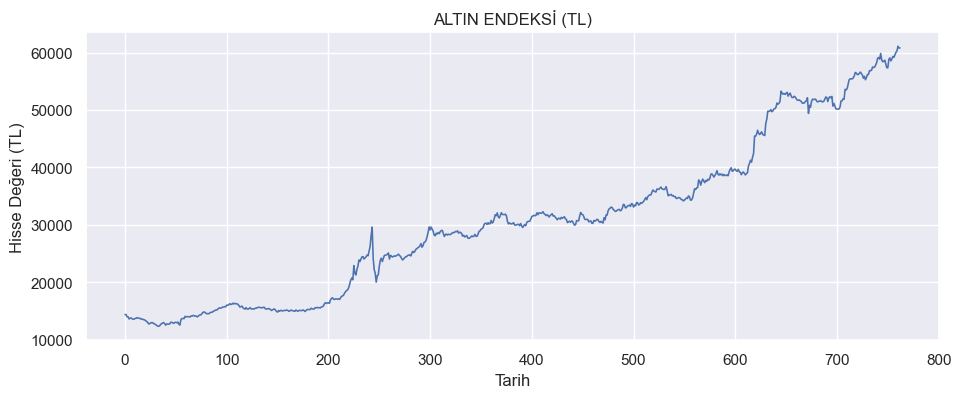

In [231]:
sns.set(rc={'figure.figsize':(11, 4)})
ax = df["Close"].plot(linestyle='-', linewidth=1.15, label='Daily')
ax.set_ylabel("Hisse Değeri (TL)")
ax.set_xlabel("Tarih")
ax.set_title("ALTIN ENDEKSİ (TL)")
plt.show();

In [232]:
# Eğitim-Doğrulama-Test seti olarak bölelim
index = df.shape[0]*0.848
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)

In [233]:
len(train), len(validation), len(test)

(647, 58, 58)

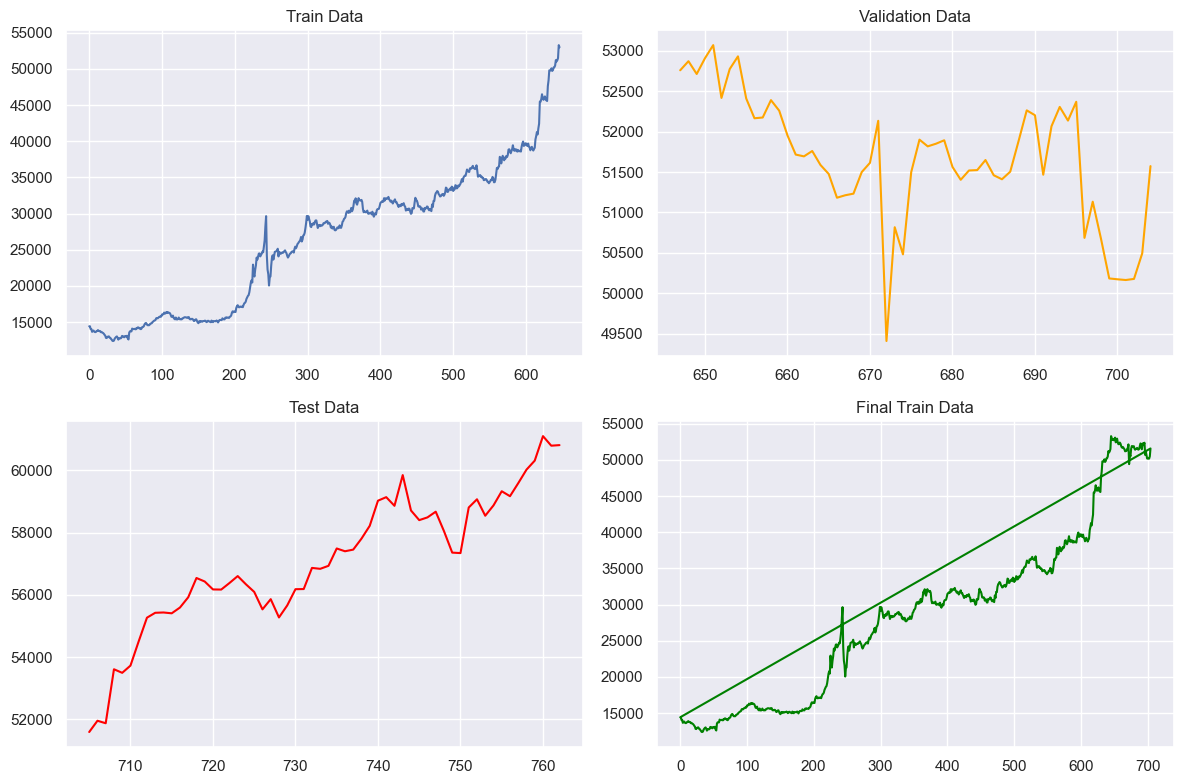

In [234]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
train.plot(ax=axes[0, 0], title="Train Data")
validation.plot(ax=axes[0, 1], title="Validation Data",color="orange")
test.plot(ax=axes[1, 0], title="Test Data",color="red")
final_train.plot(ax=axes[1, 1], title="Final Train Data",color="green")
plt.tight_layout()
plt.show();

# SES MODEL

## SES MODEL PARAMETRE OPTİMİZASYONU

In [235]:
index = df.shape[0]*0.848
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
len(train), len(validation), len(test)
def ses_optimizer(train, alphas, step=len(validation)):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        validation_pred = ses_model.forecast(step)
        mae = mean_absolute_error(validation, validation_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae
alphas = np.arange(0.01, 1, 0.01)
best_alpha, best_mae = ses_optimizer(train, alphas, step=len(validation)) 
# best_alpha: 0.22 best_mae: 603.6273

best_alpha: 0.22 best_mae: 603.6273


### ONE STEP AHEAD METHOD(SES)

In [236]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
xau_ses_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = SimpleExpSmoothing(final_train).fit(smoothing_level=best_alpha)
    output = model_fit.forecast()
    yhat = output[0]
    xau_ses_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### SES MODEL HATASI

In [237]:
xau_ses_rmse = np.sqrt(mean_squared_error(test,xau_ses_model_predictions)) # RMSE = 976.2803844833704
test = np.array(test)
xau_ses_model_predictions = np.array(xau_ses_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
xau_ses_mape = mape(test,xau_ses_model_predictions) # MAPE = 1.4475471208660544
print(xau_ses_rmse), print(xau_ses_mape);

976.2803844833704
1.4475471208660544


### SES MODELİN TAHMİN GRAFİĞİ:

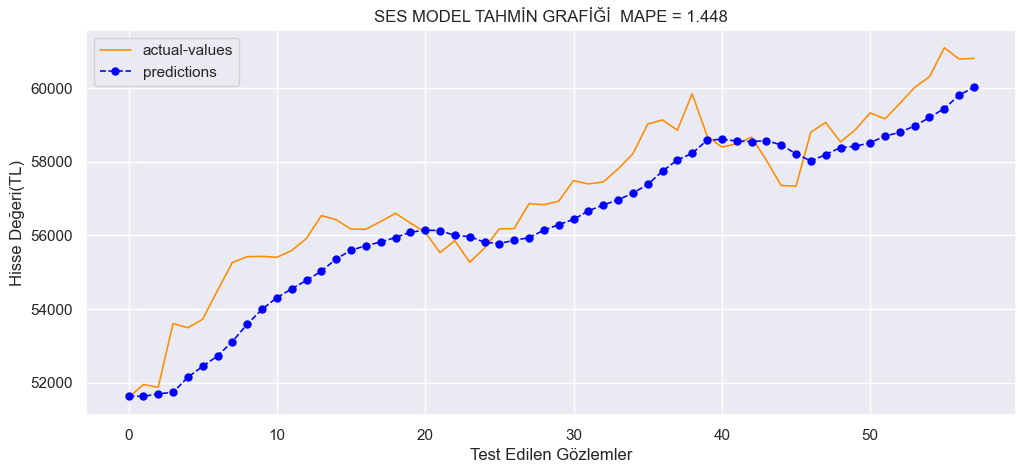

In [238]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(xau_ses_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Test Edilen Gözlemler")
plt.ylabel("Hisse Değeri(TL)")
plt.title("SES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(xau_ses_mape,3)))
plt.legend();

# DES MODEL

## DES MODEL PARAMETRE OPTİMİZASYONU

In [239]:
index = df.shape[0]*0.848
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
def des_optimizer(train, alphas, betas, step=len(validation)):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            validation_pred = des_model.forecast(step)
            mae = mean_absolute_error(validation, validation_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae
alphas = np.arange(0.01, 1, 0.01)
betas = np.arange(0.1, 1, 0.01)
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, step=len(validation))
# best_alpha: 0.05 best_beta: 0.64 best_mae: 492.3164

best_alpha: 0.05 best_beta: 0.64 best_mae: 492.3164


### ONE STEP AHEAD METHOD(DES)

In [240]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
xau_des_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = ExponentialSmoothing(final_train, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
    output = model_fit.forecast()
    yhat = output[0]
    xau_des_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### DES MODEL HATASI

In [241]:
xau_des_rmse = np.sqrt(mean_squared_error(test,xau_des_model_predictions)) # RMSE = 1608.1117250747923
test = np.array(test)
xau_des_model_predictions = np.array(xau_des_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
xau_des_mape = mape(test,xau_des_model_predictions) # MAPE = 2.353871186713825
print(xau_des_rmse),print(xau_des_mape); 

1608.1117250747923
2.353871186713825


### DES MODEL TAHMİN GRAFİĞİ:

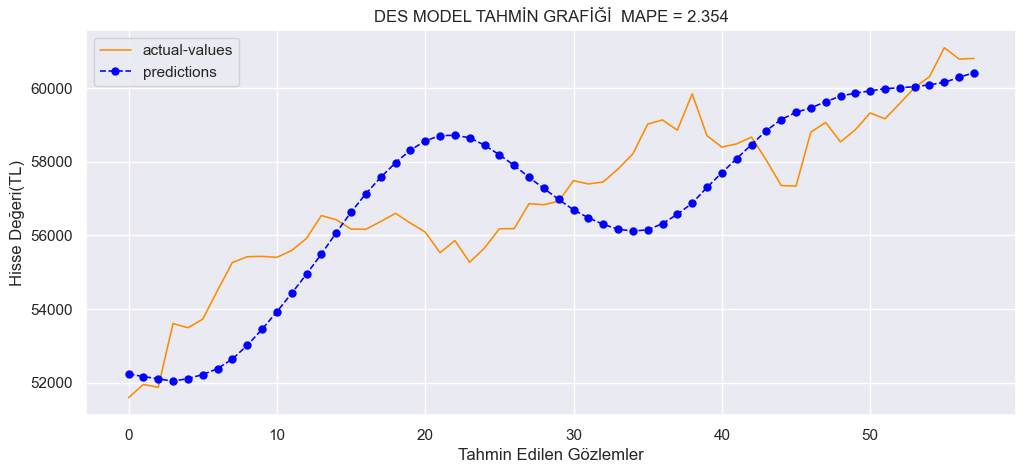

In [242]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(xau_des_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tahmin Edilen Gözlemler")
plt.ylabel("Hisse Değeri(TL)")
plt.title("DES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(xau_des_mape,3)))
plt.legend();

# TES MODEL

## TES PARAMETRE OPTİMİZASYONU

In [243]:
len(validation), len(test)

(58, 58)

In [244]:
index = df.shape[0]*(0.84774)
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
def tes_optimizer(train, abg, step=len(validation)):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        validation_pred = tes_model.forecast(step)
        mae = mean_absolute_error(validation, validation_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae
alphas = betas = gammas = np.arange(0.01, 1, 0.1)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg, step=len(validation))
# best_alpha: 0.11 best_beta: 0.71 best_gamma: 0.31 best_mae: 640.7237

best_alpha: 0.11 best_beta: 0.71 best_gamma: 0.31 best_mae: 640.7237


### ONE STEP AHEAD METHOD(TES)

In [245]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
xau_tes_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model_fit = ExponentialSmoothing(final_train, trend="add", seasonal="add", seasonal_periods=5).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
    # model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    xau_tes_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### TES MODEL HATASI

In [246]:
xau_tes_rmse = np.sqrt(mean_squared_error(test,xau_tes_model_predictions)) # RMSE = 1014.2850191384864
test = np.array(test)
xau_tes_model_predictions = np.array(xau_tes_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
xau_tes_mape = mape(test,xau_tes_model_predictions) # MAPE = 1.530213528177664
print("RMSE =",xau_tes_rmse),print("MAPE =",xau_tes_mape);

RMSE = 1014.2850191384864
MAPE = 1.530213528177664


### TES MODEL TAHMİN GRAFİĞİ:

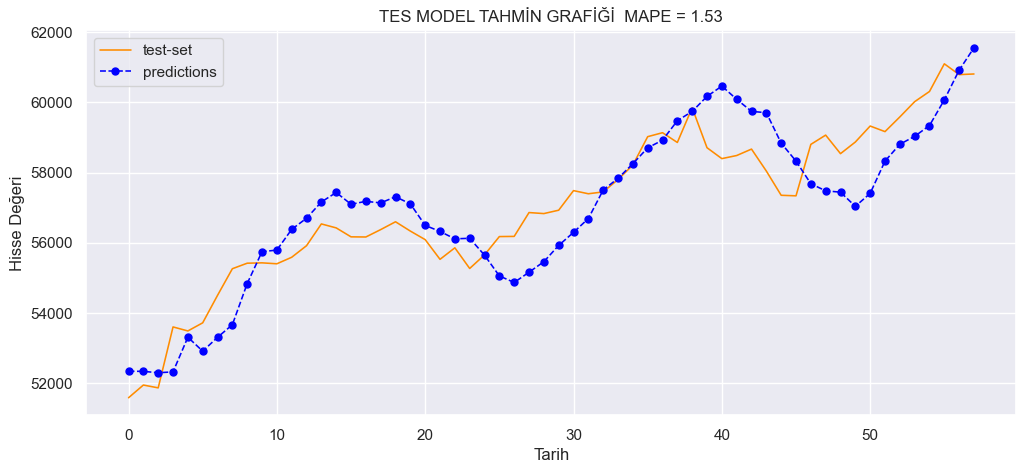

In [247]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(xau_tes_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("TES MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(xau_tes_mape,3)))
plt.legend();

# ARIMA MODEL

## ARIMA MODEL PARAMETRE OPTMİZASYONU

In [248]:
index = df.shape[0]*0.848
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model = sm.tsa.ARIMA(train, order=order).fit()
            aic = arima_model.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params
best_params_aic = arima_optimizer_aic(train, pdq)
# Best ARIMA(3, 1, 2) AIC=9713.18  <- parametreler.

Best ARIMA(3, 1, 2) AIC=9713.18


### ONE STEP AHEAD METHOD(ARIMA)

In [249]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
xau_arima_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model = sm.tsa.ARIMA(final_train, order=best_params_aic)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    xau_arima_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### ARIMA MODEL HATASI

In [250]:
xau_arima_rmse = np.sqrt(mean_squared_error(test,xau_arima_model_predictions)) # RMSE = 549.73756054384
test = np.array(test)
xau_arima_model_predictions = np.array(xau_arima_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
xau_arima_mape = mape(test,xau_arima_model_predictions) # MAPE = 0.7111665000758151
print("RMSE =",xau_arima_rmse),print("MAPE =",xau_arima_mape);

RMSE = 549.73756054384
MAPE = 0.7111665000758151


### ARIMA MODEL TAHMİN GRAFİĞİ:

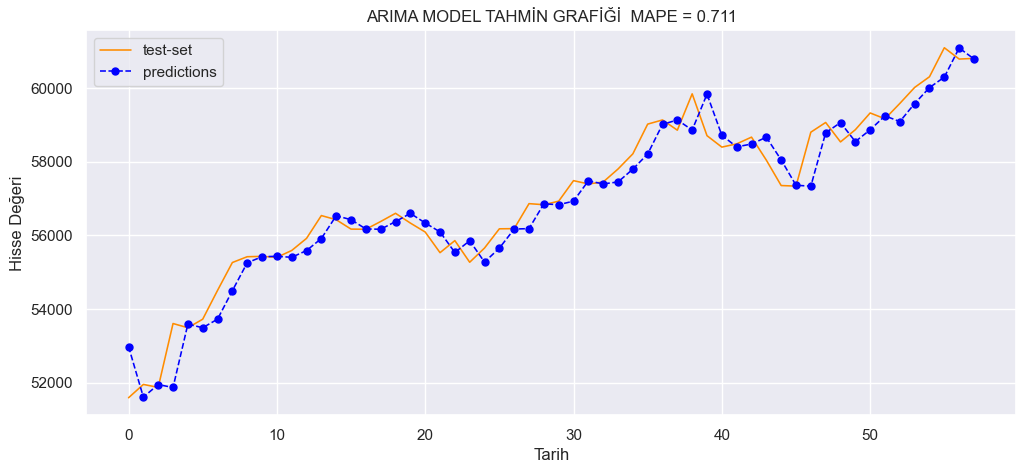

In [251]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(xau_arima_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("ARIMA MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(xau_arima_mape,3)))
plt.legend();

# SARIMA MODEL

## SARIMA MODEL PARAMETRE OPTİMİZASYONU

In [252]:
index = df.shape[0]*0.848
train = df[:int(index)]["Close"]
validation = df[int(index): int(df.shape[0]*0.925)]["Close"]
test = df[int(df.shape[0]*0.925):]["Close"]
final_train = pd.concat([validation, train], sort=False)
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 5) for x in list(itertools.product(p, d, q))]
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order
best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)
# SARIMA(1, 1, 1)x(0, 1, 1, 5)12 - AIC:9679.231289069481 <- parametreler.

SARIMA(1, 1, 1)x(0, 1, 1, 5)12 - AIC:9679.231289069481


### ONE STEP AHEAD METHOD(SARIMA)

In [253]:
train = list(train)
validation = list(validation)
test = list(test)
final_train = list(final_train)
xau_sarima_model_predictions = []
n_test_obser = len(test)
for i in range(n_test_obser):
    model = SARIMAX(final_train, order=best_order, seasonal_order=best_seasonal_order)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    xau_sarima_model_predictions.append(yhat)
    actual_test_value = test[i]
    final_train.append(actual_test_value)

### SARIMA MODEL HATASI

In [254]:
xau_sarima_rmse = np.sqrt(mean_squared_error(test,xau_sarima_model_predictions)) # RMSE = 557.3355018303776
test = np.array(test)
xau_sarima_model_predictions = np.array(xau_sarima_model_predictions)
def mape(actual, predictions):
    mape = np.mean(np.abs((actual - predictions) / actual)) * 100
    return mape
xau_sarima_mape = mape(test,xau_sarima_model_predictions) # MAPE = 0.7397903976124185
print("RMSE =",xau_sarima_rmse),print("MAPE =",xau_sarima_mape);

RMSE = 557.3355018303776
MAPE = 0.7397903976124185


### SARIMA MODEL TAHMİN GRAFİĞİ:

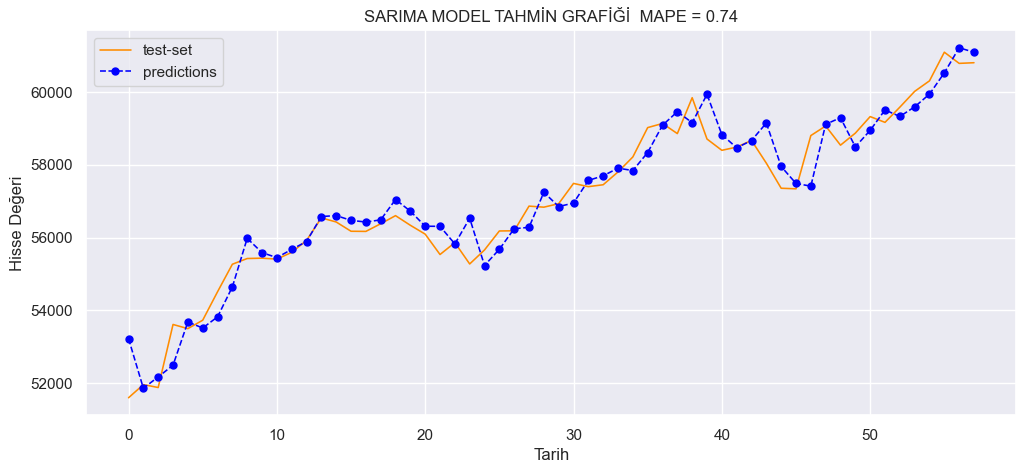

In [255]:
sns.set(rc={'figure.figsize':(12, 5)})
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'test-set')
plt.plot(xau_sarima_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("SARIMA MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(xau_sarima_mape,3)))
plt.legend();

# ANN MODEL(LSTM)

In [256]:
data = pd.read_csv("xau-try.csv")
prices = data['Close'].values

In [257]:
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

In [258]:
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)
lookback = 30

In [259]:
train_size = int(len(prices_scaled) * 0.925) 
train_data = prices_scaled[:train_size]
test_data = prices_scaled[train_size - lookback:]  
train_size, len(train_data), len(test_data)

(705, 705, 88)

In [260]:
# Ayrı ayrı veri seti oluştur
X_train, y_train = create_dataset(train_data, lookback)
X_test, y_test = create_dataset(test_data, lookback)
# LSTM için giriş verisini yeniden şekillendir
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [261]:
# Model oluştur
tf.random.set_seed(42)
model = Sequential([
    LSTM(50, activation='relu', input_shape=(lookback, 1)),
    Dense(1)])
# Modeli derle
model.compile(optimizer='adam', loss='mse')
# Modeli eğit
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1260 - val_loss: 0.0040
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6304e-04 - val_loss: 7.7048e-04
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2143e-04 - val_loss: 5.9858e-04
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.8588e-04 - val_loss: 5.6169e-04
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7041e-04 - val_loss: 5.9588e-04
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4136e-04 - val_loss: 5.0811e-04
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2268e-04 - val_loss: 4.6411e-04
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0989e-04 - val_loss: 4.4114e-04
Epoch 10/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0155e-04 - val_loss: 4.2642e-04
Epoch 11/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9556e-04 - val_loss: 4.1593e-04
Ep

In [262]:
xau_ann_pred = model.predict(X_test)
# Veriyi orijinal ölçeğe geri çevir
y_pred_ann_inverse = scaler.inverse_transform(xau_ann_pred)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
def mape(actual, predictions):
    return np.mean(np.abs((actual - predictions) / actual)) * 100
xau_ann_mape = mape(y_test_inverse, y_pred_ann_inverse)
print(xau_ann_mape) # MAPE = 1.301716786394469

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1.301716786394469


In [263]:
test = np.array(y_test_inverse)
xau_ann_model_predictions = np.array(y_pred_ann_inverse)

### ANN MODEL TAHMİN GRAFİĞİ:

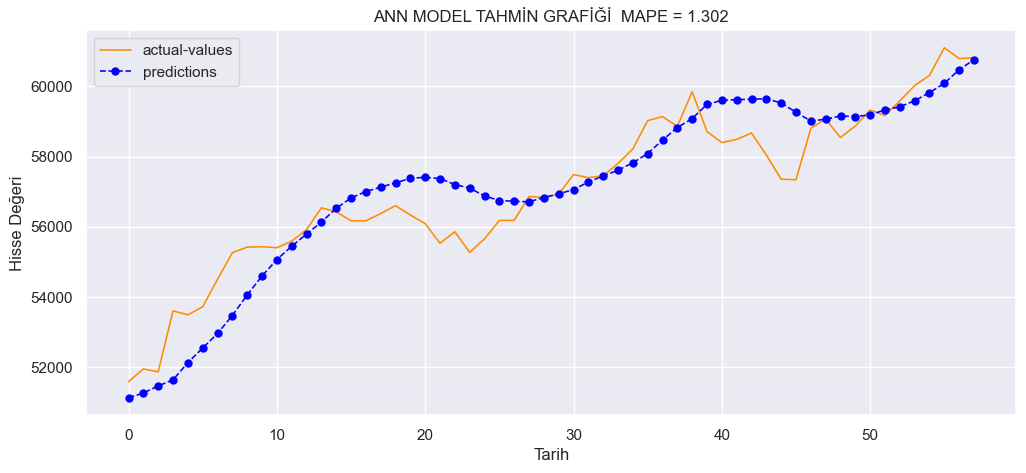

In [264]:
plt.plot(test,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(xau_ann_model_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("ANN MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(xau_ann_mape,3)))
plt.legend();

# CNN MODEL

In [265]:
from tensorflow.keras.layers import Conv1D, Dense, Flatten

In [266]:
data = pd.read_csv("xau-try.csv")
prices = data["Close"].values

In [267]:
# Parametreler
lookback = 10
test_size = 58
# Veriyi böl (lookback'i unutma!)
train_prices = prices[:-(test_size)]
test_prices = prices[-(test_size + lookback):]  # Test için lookback öncesi veriler dahil edilir
# Ölçeklendirme (sadece train'e fit et)
scaler = MinMaxScaler(feature_range=(0, 1))
train_prices_scaled = scaler.fit_transform(train_prices.reshape(-1, 1))
test_prices_scaled = scaler.transform(test_prices.reshape(-1, 1))

In [268]:
# Dataset oluşturma fonksiyonu
def create_dataset(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)
X_train, y_train = create_dataset(train_prices_scaled, lookback)
X_test, y_test = create_dataset(test_prices_scaled, lookback)

In [269]:
# CNN için reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [270]:
# Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(lookback, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
# Compile
model.compile(optimizer='adam', loss='mse')
# Eğitim
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test));

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0881 - val_loss: 0.0038
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 0.0012 - val_loss: 6.7878e-04
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 5.2188e-04 - val_loss: 6.2378e-04
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1165e-04 - val_loss: 6.5319e-04
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 5.0412e-04 - val_loss: 6.7031e-04
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 4.9654e-04 - val_loss: 6.7514e-04
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - loss: 4.8884e-04 - val_loss: 6.6954e-04
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8095e-04 - val_loss: 6.6362e-04
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 4.7296e-04 - val_loss: 6.6054e-04
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 4.6476e-04 - val_loss: 6.6073e-04
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 4.5648e-04 - val

In [271]:
y_pred_scaled = model.predict(X_test)
xau_cnn_y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
def mape(actual, pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100
xau_cnn_mape = mape(y_test_inverse, xau_cnn_y_pred)
print(f"Test MAPE: {xau_cnn_mape}") # Test MAPE: 1.6347147012626309

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Test MAPE: 1.6347147012626309


In [288]:
xau_ann_rmse = np.sqrt(mean_squared_error(test,xau_ann_model_predictions)) # RMSE = 943.2004350034877
print(xau_ann_rmse);

943.2004350034877


###  CNN MODEL TAHMİN GRAFİĞİ:

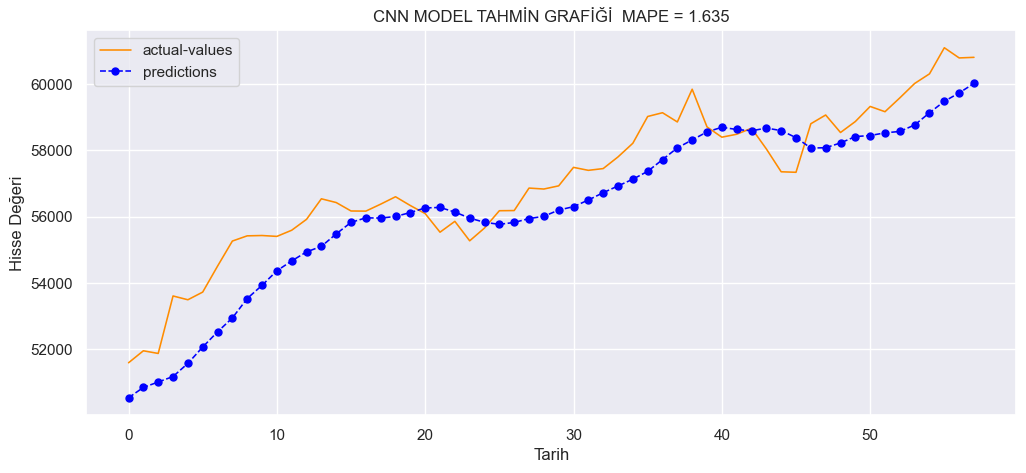

In [272]:
import matplotlib.pyplot as plt
plt.plot(y_test_inverse,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(xau_cnn_y_pred,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("CNN MODEL TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(xau_cnn_mape,3)))
plt.legend();

#

## KOMBİNASYON YÖNTEMİ VE BAŞARISI

## YÖNTEMLERİN MAPE DEĞERLERİ:

In [273]:
best_model = pd.DataFrame([xau_ses_mape, xau_des_mape, xau_tes_mape,
                           xau_arima_mape, xau_sarima_mape,
                           xau_ann_mape, xau_cnn_mape],

                          index=["SES MODEL", "DES MODEL", "TES MODEL", "ARIMA MODEL", "SARIMA MODEL","ANN MODEL","CNN MODEL"],

                          columns=["MAPE Değerleri"])
print(best_model.sort_values("MAPE Değerleri", ascending=True));

              MAPE Değerleri
ARIMA MODEL         0.711167
SARIMA MODEL        0.739790
ANN MODEL           1.301717
SES MODEL           1.447547
TES MODEL           1.530214
CNN MODEL           1.634715
DES MODEL           2.353871


**EN DÜŞÜK MAPE DEĞERİNE SAHİP 3 YÖNTEMİN ORTALAMASINI ALALIM**

In [278]:
predictions = np.stack([xau_arima_model_predictions.flatten(),xau_sarima_model_predictions.flatten(),xau_ann_model_predictions.flatten()], axis=1)

# Bu tahminlerin ortalaması:
average_predictions = np.mean(predictions, axis=1)

print(average_predictions)

[52445.50920964 51578.18720012 51863.02716687 52001.61663072
 53135.24809533 53185.26879819 53502.45860953 54205.34833036
 55098.25957584 55202.48335339 55315.29925467 55509.19055711
 55757.39875207 56209.32811178 56553.68986725 56573.7250879
 56534.46476518 56593.89787648 56891.05492757 56899.75873042
 56686.32056323 56591.52380795 56188.035948   56495.1251165
 55795.11773226 56026.38230103 56380.96880307 56392.07173908
 56977.63970105 56874.52818747 56978.52860344 57441.798641
 57514.68231864 57656.26784004 57821.43693197 58211.02146365
 58856.54315857 59139.85435576 59033.28073213 59751.39330184
 59049.73272486 58829.928321   58925.68434659 59154.28812845
 58508.60251566 58036.16715919 57919.48766262 58987.63010085
 59170.59671527 58725.35072775 59000.30623251 59360.51071708
 59278.78212001 59586.42510751 59925.30756926 60303.18903078
 60925.91525822 60879.85857721]


**KOMBİNE EDİLEN TAHMİNLERİN MAPE DEĞERİ**

In [279]:
from sklearn.metrics import mean_absolute_percentage_error
combined_mape = mean_absolute_percentage_error(test,average_predictions)*100
print(combined_mape) #  MAPE = 0.8001793064908386

0.8001793064908386


# 

In [293]:
best_model = pd.DataFrame([xau_arima_mape, xau_sarima_mape,
                           xau_ann_mape,combined_mape],

                          index=["ARIMA MODEL", "SARIMA MODEL","ANN MODEL","COMBINED PREDICTION"],

                          columns=["XAU-TRY MAPE Değerleri"])
print(best_model.sort_values("XAU-TRY MAPE Değerleri", ascending=True));

                     XAU-TRY MAPE Değerleri
ARIMA MODEL                        0.711167
SARIMA MODEL                       0.739790
COMBINED PREDICTION                0.800179
ANN MODEL                          1.301717


In [290]:
combined_RMSE = np.sqrt(mean_squared_error(test,average_predictions)) # RMSE = 580.8276333764427
print(combined_RMSE);

580.8276333764427


In [294]:
best_model_RMSE = pd.DataFrame([xau_arima_rmse, xau_sarima_rmse,
                           xau_ann_rmse, combined_RMSE],

                          index=["ARIMA MODEL", "SARIMA MODEL","ANN MODEL","COMBINED PREDICTION"],

                          columns=["XAU-TRY RMSE Değerleri"])
print(best_model_RMSE.sort_values("XAU-TRY RMSE Değerleri", ascending=True));

                     XAU-TRY RMSE Değerleri
ARIMA MODEL                      549.737561
SARIMA MODEL                     557.335502
COMBINED PREDICTION              580.827633
ANN MODEL                        943.200435


**YÖNTEMLERİN MAPE DEĞERLERİ BİRBİRİNE ÇOK YAKIN GELMİŞTİR. KOMBİNASYON İLE ELDE EDİLEN TAHMİNLERİN MAPE DEĞERİ 3. SIRADA YER ALMIŞTIR!**

## KOMBİNE TAHMİNLERİN GRAFİĞİ:

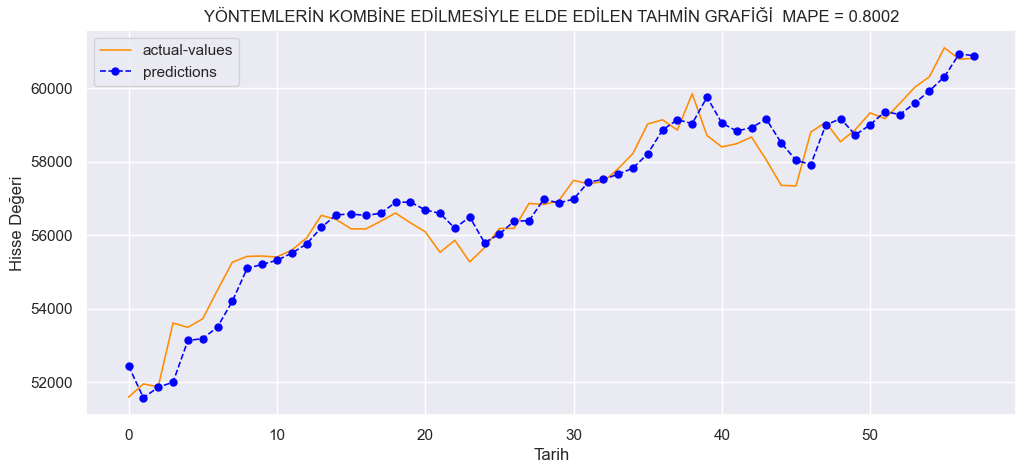

In [283]:
import matplotlib.pyplot as plt
plt.plot(y_test_inverse,linestyle='-', linewidth=1.15, color="darkorange", label = 'actual-values')
plt.plot(average_predictions,linestyle='dashed', linewidth=1.15, color="blue", marker="o",markersize=5, label = 'predictions')
plt.xlabel("Tarih")
plt.ylabel("Hisse Değeri")
plt.title("YÖNTEMLERİN KOMBİNE EDİLMESİYLE ELDE EDİLEN TAHMİN GRAFİĞİ  "+ "MAPE = " + str(round(combined_mape,4)))
plt.legend();